In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 1. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 40000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

2000000000.0


In [7]:
Eb

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.    ])

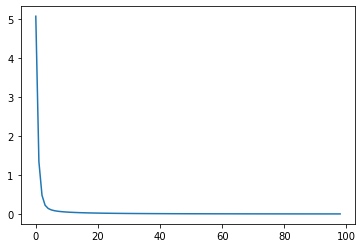

In [8]:
plt.plot(S)

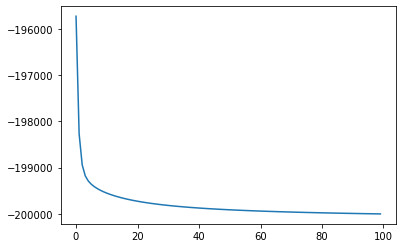

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.002105977685539983

In [11]:
eta

array([-195729.38238575, -198267.07979135, -198938.92749255,
       -199178.03687554, -199290.07820991, -199360.70592266,
       -199413.20476929, -199455.61163874, -199491.48393352,
       -199522.69582972, -199550.3622296 , -199575.2075091 ,
       -199597.73454761, -199618.31071785, -199637.21532905,
       -199654.66756629, -199670.84385302, -199685.8891399 ,
       -199699.92453433, -199713.05263213, -199725.36135382,
       -199736.92677651, -199747.81527199, -199758.08515341,
       -199767.78796611, -199776.96951525, -199785.67069538,
       -199793.92816828, -199801.77492301, -199809.24074298,
       -199816.35259895, -199823.13498231, -199829.61018955,
       -199835.79856665, -199841.7187203 , -199847.3877012 ,
       -199852.82116404, -199858.0335076 , -199863.03799798,
       -199867.84687733, -199872.47146016, -199876.92221882,
       -199881.20885966, -199885.34039101, -199889.32518407,
       -199893.17102748, -199896.88517642, -199900.47439685,
       -199903.9450054 ,

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.27001772e+03, 1.73232032e+03, 1.06047262e+03, 8.21363235e+02,
       7.09321900e+02, 6.38694188e+02, 5.86195341e+02, 5.43788472e+02,
       5.07916177e+02, 4.76704281e+02, 4.49037881e+02, 4.24192601e+02,
       4.01665563e+02, 3.81089392e+02, 3.62184781e+02, 3.44732544e+02,
       3.28556257e+02, 3.13510970e+02, 2.99475576e+02, 2.86347478e+02,
       2.74038756e+02, 2.62473334e+02, 2.51584838e+02, 2.41314957e+02,
       2.31612144e+02, 2.22430595e+02, 2.13729415e+02, 2.05471942e+02,
       1.97625187e+02, 1.90159367e+02, 1.83047511e+02, 1.76265128e+02,
       1.69789921e+02, 1.63601544e+02, 1.57681390e+02, 1.52012409e+02,
       1.46578946e+02, 1.41366603e+02, 1.36362112e+02, 1.31553233e+02,
       1.26928650e+02, 1.22477891e+02, 1.18191251e+02, 1.14059719e+02,
       1.10074926e+02, 1.06229083e+02, 1.02514934e+02, 9.89257134e+01,
       9.54551048e+01, 9.20972048e+01, 8.88464902e+01, 8.56977892e+01,
       8.26462535e+01, 7.96873343e+01, 7.68167596e+01, 7.40305143e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_5.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_5.csv', alpha, delimiter = ',')